## Load training datas

### Imports

In [1]:
base_dir = '/home/alwyn/Developer/ut/CSC311H1/csc311-project/'
starter_code_dir = base_dir + 'part_a/'
data_dir = base_dir + 'data/'
import os
os.listdir(base_dir)
os.listdir(starter_code_dir)
os.listdir(data_dir)

['question_meta.csv',
 'student_meta.csv',
 'subject_meta.csv',
 'test_data.csv',
 'train_data.csv',
 'train_sparse.npz',
 'valid_data.csv',
 '.ipynb_checkpoints']

In [2]:
import sys
sys.path.append(base_dir)
sys.path.append(data_dir)

In [3]:
from utils import *
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import numpy as np
import torch


In [4]:
import matplotlib.pyplot as plt

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
import tqdm
import math

In [7]:
import gc

### Original training data

In [8]:
def load_data(base_path="../data"):
    """ Load the data in PyTorch Tensor.

    :return: (zero_train_matrix, train_data, valid_data, test_data)
        WHERE:
        zero_train_matrix: 2D sparse matrix where missing entries are
        filled with 0.
        train_data: 2D sparse matrix
        valid_data: A dictionary {user_id: list,
        user_id: list, is_correct: list}
        test_data: A dictionary {user_id: list,
        user_id: list, is_correct: list}
    """
    train_matrix = load_train_sparse(base_path).toarray()
    valid_data = load_valid_csv(base_path)
    test_data = load_public_test_csv(base_path)

    zero_train_matrix = train_matrix.copy()
    # Fill in the missing entries to 0.
    zero_train_matrix[np.isnan(train_matrix)] = 0
    # Change to Float Tensor for PyTorch.
    zero_train_matrix = torch.FloatTensor(zero_train_matrix)
    train_matrix = torch.FloatTensor(train_matrix)

    return zero_train_matrix, train_matrix, valid_data, test_data

In [9]:
zero_train_matrix, train_matrix, valid_data, test_data = load_data(data_dir)
train_matrix_gpu = train_matrix.to(device)
zero_train_matrix_gpu = zero_train_matrix.to(device)

### Question Metadata

In [10]:
import pandas as pd
import json

get the number of questions and number of subjects, make a question matrix such that the i'th question is in the j'th subject iff `question_matrix[i][j]==1`

In [11]:
question_df = pd.read_csv(data_dir + 'question_meta.csv')
num_questions = question_df.shape[0]
subject_df = pd.read_csv(data_dir + 'subject_meta.csv')
num_subjects = subject_df.shape[0]
question_matrix = np.zeros((num_questions, num_subjects), dtype=int)
for _, row in question_df.iterrows():
    li = json.loads(row.subject_id)
    for i in li:
        question_matrix[row.question_id, i] = 1

In [12]:
question_matrix.shape

(1774, 388)

Clean the data further, remove all the columns of `question_matrix` that consists of only 1's or 0's

In [13]:
question_matrix = question_matrix[:, ~((question_matrix == 1).all(axis=0) | (question_matrix == 0).all(axis=0))]
question_matrix.shape

(1774, 288)

In [14]:
num_subject = question_matrix.shape[1]
num_subject

288

In [15]:
non_zero = question_matrix.nonzero()
non_zero

(array([   0,    0,    0, ..., 1773, 1773, 1773]),
 array([ 37,  41, 112, ...,   0,   1,  89]))

Make the subjects of each quesion in the form of a list of `torch.LongTensor` so that we can put each into a `EmbeddingBag` in our nn

In [16]:
non_zero_row, non_zero_col = non_zero
subjects = []
for i in range(num_questions):
    subjects.append(torch.LongTensor(non_zero_col[non_zero_row == i]).unsqueeze(0))
subjects[:5]

[tensor([[ 37,  41, 112]]),
 tensor([[ 16,  22, 197]]),
 tensor([[  0,  89, 137]]),
 tensor([[  0,   7, 154]]),
 tensor([[16, 31, 93]])]

In [17]:
subjects_gpu = [t.to(device) for t in subjects]
subjects_gpu[:5]

[tensor([[ 37,  41, 112]], device='cuda:0'),
 tensor([[ 16,  22, 197]], device='cuda:0'),
 tensor([[  0,  89, 137]], device='cuda:0'),
 tensor([[  0,   7, 154]], device='cuda:0'),
 tensor([[16, 31, 93]], device='cuda:0')]

This output should contain all the subjects from the csv, except the subjects where all the questions are in, and the indices should be changed since all-0 columns are also dropped

### Student Metadata

In [18]:
student_df = pd.read_csv(data_dir + 'student_meta.csv', index_col='user_id')
student_df

,gender,data_of_birth,premium_pupil
user_id,,,
66,1,2002-12-01 00:00:00.000,NaN
447,2,NaN,NaN
422,1,2006-08-01 00:00:00.000,NaN
302,2,2009-07-01 00:00:00.000,0.0
361,1,NaN,NaN
...,...,...,...
155,1,2010-12-01 00:00:00.000,0.0
54,2,2007-05-01 00:00:00.000,NaN
511,2,2006-04-01 00:00:00.000,0.0


In [19]:
genders = torch.tensor(student_df['gender'].to_numpy())
genders

tensor([1, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2,
        0, 1, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 0, 1, 0, 2, 2, 2, 2,
        0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 2,
        2, 1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2, 0, 1, 2,
        2, 2, 1, 0, 0, 1, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2,
        2, 2, 0, 1, 1, 0, 2, 0, 2, 0, 1, 1, 0, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 1,
        1, 2, 0, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 1, 2, 0, 0, 2, 0, 1, 1, 2, 1, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2,
        1, 0, 2, 2, 2, 1, 1, 2, 0, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 0, 1, 0, 0, 0,
        2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 0, 2, 0, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2,
        1, 2, 1, 1, 1, 0, 1, 0, 2, 1, 0, 0, 1, 1, 2, 0, 2, 0, 2, 1, 0, 1, 0, 1,
        0, 1, 2, 2, 0, 0, 1, 0, 1, 1, 0,

## Define network

In [20]:
def evaluate(model, subjects, train_data, valid_data):
    """ Evaluate the valid_data on the current model.

    :param model: Module
    :param train_data: 2D FloatTensor
    :param valid_data: A dictionary {user_id: list,
    question_id: list, is_correct: list}
    :return: float
    """
    # Tell PyTorch you are evaluating the model.
    print("validating", end=" ")
    model.eval()

    total = 0
    correct = 0

    for i, u in enumerate(valid_data["user_id"]):
        # print(i, end=" ")
        inputs = Variable(train_data[u]).unsqueeze(0)
        output = model(subjects, inputs)

        guess = output[0][valid_data["question_id"][i]].item() >= 0.5
        if guess == valid_data["is_correct"][i]:
            correct += 1
        total += 1
    return correct / float(total)

In [21]:
def train(model, lr, subjects, train_data, zero_train_data, valid_data, num_epoch, batch_size):
    # assert len(subjects) == train_data.shape[1]
    # assert (zero_train_data.shape == train_data.shape).all()

    model.train()

    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_iter = math.ceil(train_data.shape[0] / batch_size)
    
    train_losses = []
    valid_accs = []
    for epoch in range(num_epoch):
        print("starting epoch ", epoch)
        indices = torch.randperm(train_data.shape[0])
        train_loss = 0.
        print("at batch: ")
        for i in range(num_iter):
            if i % 10 == 0:
                print(i, end=" ")
            start = i * batch_size
            end = start + batch_size
            sub_indices = indices[start:end]
            
            input = Variable(zero_train_data[sub_indices])
            target = input.clone()

            optimizer.zero_grad()
            output = model.forward(subjects, input)
            
            mask = torch.isnan(zero_train_data[sub_indices])
            target[mask] = output[mask]

            loss = F.mse_loss(output, target, reduction="mean")
            loss.backward()

            train_loss += loss.item()
            optimizer.step()
        # valid_acc = 0
        valid_acc = evaluate(model, subjects, zero_train_data, valid_data)
        print("\nEpoch: {} \tTraining Cost: {:.6f}\t "
              "Valid Acc: {}".format(epoch, train_loss, valid_acc))
        train_losses.append(train_loss)
        valid_accs.append(valid_acc)
        
    x = list(range(num_epoch))
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(x, train_losses)
    ax[0].set_title("Training Loss")
    ax[1].plot(x, valid_accs)
    ax[1].set_title("Validation")
    plt.tight_layout()
    plt.show()
    print("highest valid acc: ", np.max(valid_accs), " in epoch: ", np.argmax(valid_accs))
    print("lowest training err: ", np.min(train_losses), " in epoch ", np.argmin(train_losses))

In [22]:
class EmbeddedAutoEncoder(nn.Module):
    def __init__(self, num_questions, num_subjects, embed_dim=100, p=0.5):
        super(EmbeddedAutoEncoder, self).__init__()
        
        self.num_subjects = num_subjects
        self.num_questions = num_questions
        self.embed_dim = embed_dim
        self.p = p

        self.embedder = nn.EmbeddingBag(num_subjects, embed_dim, mode="mean")

        self.layers = nn.ModuleList([
            nn.Linear(embed_dim * num_questions, 10000),
            nn.ReLU(),
            nn.Linear(10000, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(200, 500),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, num_questions),
            nn.Sigmoid(),
        ])

    def forward(self, subjects, train_data):
        embeddings = []
        for s in subjects:
            embeddings.append(self.embedder(s))
        x = torch.cat(embeddings, axis=-1)
        x = x * train_data.repeat_interleave(self.embed_dim,1)
        for layer in self.layers:
            x = layer(x)
        return x

In [57]:
model = EmbeddedAutoEncoder(train_matrix_gpu.shape[1], num_subject, embed_dim=10, p=0.5).to(device)

lr=0.01
num_epoch=100
batch_size=10
train(model, lr=lr, subjects=subjects_gpu, train_data=train_matrix_gpu, zero_train_data=zero_train_matrix_gpu, valid_data=valid_data, 
      num_epoch=num_epoch, batch_size=batch_size)

starting epoch  0
at batch: 
0 10 20 

KeyboardInterrupt: 

In [47]:
evaluate(model, subjects_gpu, zero_train_matrix_gpu, valid_data)

validating 

0.46429579452441433

## Finding Models

In [23]:
class EmbeddedAutoEncoder(nn.Module):
    def __init__(self, num_questions, num_subjects, embed_dim=100, p=0.5):
        super(EmbeddedAutoEncoder, self).__init__()
        
        self.num_subjects = num_subjects
        self.num_questions = num_questions
        self.embed_dim = embed_dim
        self.p = p

        self.embedder = nn.EmbeddingBag(num_subjects, embed_dim, mode="mean")

        self.layers = nn.ModuleList([
            nn.Linear(embed_dim * num_questions, 1000),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Dropout(p=p),
            # nn.Linear(200, 200),
            nn.Linear(200, 1000),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(1000, num_questions),
            nn.Sigmoid(),
        ])

    def forward(self, subjects, train_data):
        embeddings = []
        for s in subjects:
            embeddings.append(self.embedder(s))
        x = torch.cat(embeddings, axis=-1)
        x = x * train_data.repeat_interleave(self.embed_dim,1)
        for layer in self.layers:
            x = layer(x)
        return x

In [24]:
def train_plot_gpu(model, lr, subjects, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """
    # TODO: Add a regularizer to the cost function.

    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_student = train_data.shape[0]
    train_losses = []
    valid_accs = []

    for epoch in range(0, num_epoch):
        train_loss = 0.

        for user_id in range(num_student):
            inputs = Variable(zero_train_data[user_id]).unsqueeze(0)
            target = inputs.clone()

            optimizer.zero_grad()
            output = model(subjects, inputs)

            # Mask the target to only compute the gradient of valid entries.
            nan_mask = torch.isnan(train_data[user_id].unsqueeze(0))
            target[0:1][nan_mask] = output[0:1][nan_mask]

            # loss = F.cross_entropy(output, target)
            # loss = torch.sum((output - target) ** 2.)
            loss = F.mse_loss(output, target, reduction="sum")
            # loss = loss + lamb/2 * model.get_weight_norm()
            loss.backward()

            train_loss += loss.item()
            optimizer.step()
        if epoch % 10 == 1:
            valid_acc = evaluate(model, subjects, zero_train_data, valid_data)
        else:
            valid_acc=0

        print("Epoch: {} \tTraining Cost: {:.6f}\t "
              "Valid Acc: {}".format(epoch, train_loss, valid_acc))
        train_losses.append(train_loss)
        valid_accs.append(valid_acc)
    x = list(range(num_epoch))
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(x, train_losses)
    ax[0].set_title("Training Loss")
    ax[1].plot(x, valid_accs)
    ax[1].set_title("Validation")
    plt.tight_layout()
    plt.show()
    print("highest valid acc: ", np.max(valid_accs), " in epoch: ", np.argmax(valid_accs))
    print("lowest training err: ", np.min(train_losses), " in epoch ", np.argmin(train_losses))

In [25]:
def evaluate(model, subjects, train_data, valid_data):
    """ Evaluate the valid_data on the current model.

    :param model: Module
    :param train_data: 2D FloatTensor
    :param valid_data: A dictionary {user_id: list,
    question_id: list, is_correct: list}
    :return: float
    """
    # Tell PyTorch you are evaluating the model.
    model.eval()

    total = 0
    correct = 0

    for i, u in enumerate(valid_data["user_id"]):
        inputs = Variable(train_data[u]).unsqueeze(0)
        output = model(subjects, inputs)

        guess = output[0][valid_data["question_id"][i]].item() >= 0.5
        if guess == valid_data["is_correct"][i]:
            correct += 1
        total += 1
    return correct / float(total)


In [26]:
model = EmbeddedAutoEncoder(train_matrix_gpu.shape[1], num_subject, embed_dim=10, p=0.5).to(device)

lr=0.01
num_epoch=100
batch_size=10
train_plot_gpu(model, lr=lr, subjects=subjects_gpu, train_data=train_matrix_gpu, zero_train_data=zero_train_matrix_gpu, valid_data=valid_data, 
      num_epoch=num_epoch)

Epoch: 0 	Training Cost: 13777.634225	 Valid Acc: 0
Epoch: 1 	Training Cost: 12942.322223	 Valid Acc: 0.6264465142534575
Epoch: 2 	Training Cost: 12295.970273	 Valid Acc: 0
Epoch: 3 	Training Cost: 11673.422376	 Valid Acc: 0
Epoch: 4 	Training Cost: 11297.323585	 Valid Acc: 0
Epoch: 5 	Training Cost: 11092.993082	 Valid Acc: 0
Epoch: 6 	Training Cost: 10603.845365	 Valid Acc: 0
Epoch: 7 	Training Cost: 10363.408291	 Valid Acc: 0
Epoch: 8 	Training Cost: 9954.714923	 Valid Acc: 0
Epoch: 9 	Training Cost: 9731.049780	 Valid Acc: 0
Epoch: 10 	Training Cost: 9563.649203	 Valid Acc: 0
Epoch: 11 	Training Cost: 9348.747466	 Valid Acc: 0.6731583403895004
Epoch: 12 	Training Cost: 9193.521395	 Valid Acc: 0
Epoch: 13 	Training Cost: 9039.889617	 Valid Acc: 0
Epoch: 14 	Training Cost: 8928.931871	 Valid Acc: 0
Epoch: 15 	Training Cost: 8813.937104	 Valid Acc: 0
Epoch: 16 	Training Cost: 8350.058333	 Valid Acc: 0
Epoch: 17 	Training Cost: 8105.897125	 Valid Acc: 0
Epoch: 18 	Training Cost: 8038.3

KeyboardInterrupt: 

try to accelerate

In [62]:
class EmbeddedAutoEncoder(nn.Module):
    def __init__(self, num_questions, num_subjects, subjects, embed_dim=100, p=0.5):
        super(EmbeddedAutoEncoder, self).__init__()
        
        self.num_subjects = num_subjects
        self.num_questions = num_questions
        self.embed_dim = embed_dim
        self.p = p

        subjects_flat = [s.flatten() for s in subjects]
        max_length = max(len(s) for s in subjects_flat)
        constant = num_subjects
        padded_subjects = [torch.nn.functional.pad(s, (0, max_length - len(s)), "constant", constant) for s in subjects_flat]
        self.combined_subjects = torch.stack(padded_subjects).view(-1)  # Shape: [batch_size, max_length]
        self.combined_subjects = self.combined_subjects.to(device)
        self.offsets = torch.arange(0, num_questions * max_length, max_length, dtype=torch.long).to(device)

        self.embedder = nn.EmbeddingBag(num_subjects+1, embed_dim, mode="mean")

        self.layers = nn.ModuleList([
            nn.Linear(embed_dim * num_questions, 1000),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Dropout(p=p),
            # nn.Linear(200, 200),
            nn.Linear(200, 1000),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(1000, num_questions),
            nn.Sigmoid(),
        ])

    def forward(self, input):
        # print(self.combined_subjects.shape)
        # print(self.offsets)
        x = self.embedder(self.combined_subjects, self.offsets)
        x = x.flatten()
        x = x.unsqueeze(0)
        x = x * input.repeat_interleave(self.embed_dim,1)
        for layer in self.layers:
            x = layer(x)
        return x

In [49]:
def evaluate(model, train_data, valid_data):
    """ Evaluate the valid_data on the current model.

    :param model: Module
    :param train_data: 2D FloatTensor
    :param valid_data: A dictionary {user_id: list,
    question_id: list, is_correct: list}
    :return: float
    """
    # Tell PyTorch you are evaluating the model.
    model.eval()

    total = 0
    correct = 0

    for i, u in enumerate(valid_data["user_id"]):
        inputs = Variable(train_data[u]).unsqueeze(0)
        output = model(inputs)

        guess = output[0][valid_data["question_id"][i]].item() >= 0.5
        if guess == valid_data["is_correct"][i]:
            correct += 1
        total += 1
    return correct / float(total)

In [67]:
def train_plot_gpu(model, lr, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """
    # TODO: Add a regularizer to the cost function.

    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_student = train_data.shape[0]
    train_losses = []
    valid_accs = []

    for epoch in range(0, num_epoch):
        train_loss = 0.

        for user_id in range(num_student):
            inputs = Variable(zero_train_data[user_id]).unsqueeze(0)
            target = inputs.clone()

            optimizer.zero_grad()
            output = model(inputs)

            # Mask the target to only compute the gradient of valid entries.
            nan_mask = torch.isnan(train_data[user_id].unsqueeze(0))
            target[0:1][nan_mask] = output[0:1][nan_mask]

            # loss = F.cross_entropy(output, target)
            # loss = torch.sum((output - target) ** 2.)
            loss = F.mse_loss(output, target, reduction="sum")
            # loss = loss + lamb/2 * model.get_weight_norm()
            loss.backward()

            train_loss += loss.item()
            optimizer.step()
        if epoch % 2 == 1:
            valid_acc = evaluate(model, zero_train_data, valid_data)
            valid_accs.append(valid_acc)
        else:
            valid_acc = 0

        print("Epoch: {} \tTraining Cost: {:.6f}\t "
              "Valid Acc: {}".format(epoch, train_loss, valid_acc))
        train_losses.append(train_loss)
    x = list(range(num_epoch))
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(train_losses)
    ax[0].set_title("Training Loss")
    ax[1].plot(valid_accs)
    ax[1].set_title("Validation")
    plt.tight_layout()
    plt.show()
    print("highest valid acc: ", np.max(valid_accs), " in epoch: ", np.argmax(valid_accs))
    print("lowest training err: ", np.min(train_losses), " in epoch ", np.argmin(train_losses))

Epoch: 0 	Training Cost: 13892.964820	 Valid Acc: 0
Epoch: 1 	Training Cost: 12897.390257	 Valid Acc: 0.6270110076206604
Epoch: 2 	Training Cost: 12262.235284	 Valid Acc: 0
Epoch: 3 	Training Cost: 11751.869220	 Valid Acc: 0.6445103020039514
Epoch: 4 	Training Cost: 11337.563972	 Valid Acc: 0
Epoch: 5 	Training Cost: 10976.269258	 Valid Acc: 0.6713237369460909
Epoch: 6 	Training Cost: 10767.449447	 Valid Acc: 0
Epoch: 7 	Training Cost: 10435.919815	 Valid Acc: 0.6847304544171606
Epoch: 8 	Training Cost: 10223.570686	 Valid Acc: 0
Epoch: 9 	Training Cost: 9979.141842	 Valid Acc: 0.682895850973751


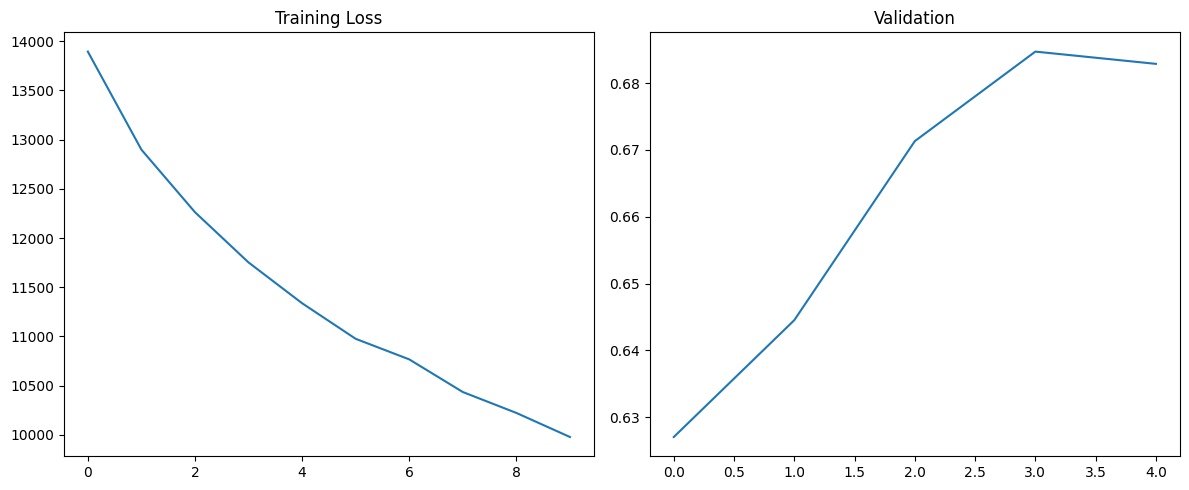

highest valid acc:  0.6847304544171606  in epoch:  3
lowest training err:  9979.141841948032  in epoch  9


In [68]:
model = EmbeddedAutoEncoder(train_matrix_gpu.shape[1], num_subject, subjects, embed_dim=10, p=0.5).to(device)

lr=0.01
num_epoch=10
batch_size=10
train_plot_gpu(model, lr=lr, train_data=train_matrix_gpu, zero_train_data=zero_train_matrix_gpu, valid_data=valid_data, 
      num_epoch=num_epoch)